In [28]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from run_sem_with_features import preprocess_skel

pn.extension()

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] Select(options=['1.1.1', '1.1.2', ...], value='1.1.1')
    [2] Row
        [0] DiscreteSlider(formatter='%d', name='Select Frame', options=[114, 120, 129, ...], value=114, value_throttled=114)
        [1] TextInput(name='Second', placeholder='Enter timepoint (...)
        [2] Checkbox(name='Display Skeleton?')
        [3] Checkbox(name='Display Nearest O...)
        [4] Checkbox(name='Z-score time courses?')
    [3] Row
        [0] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
        [1] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
        [2] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
        [3] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
    [4] Row
        [0] ParamFunction(function)
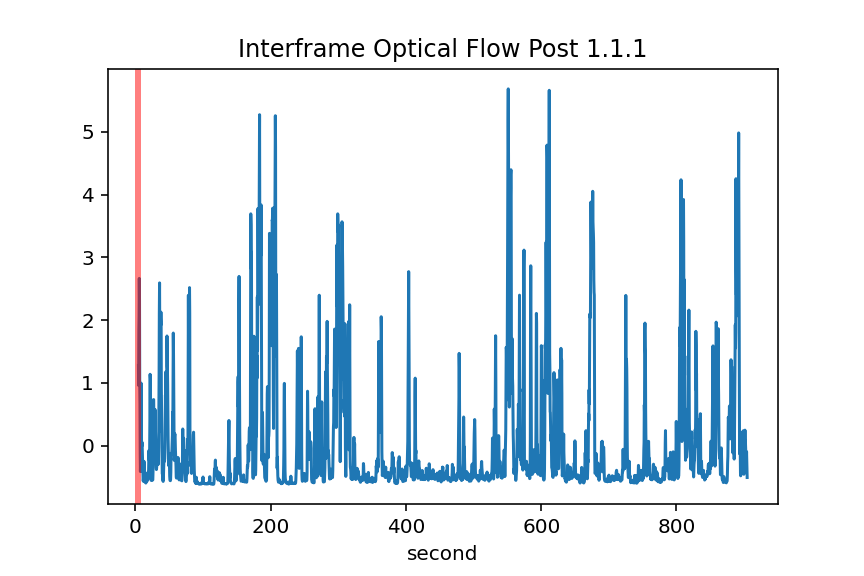
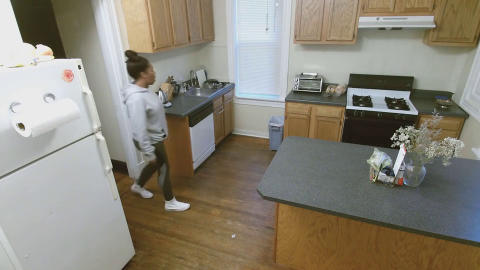
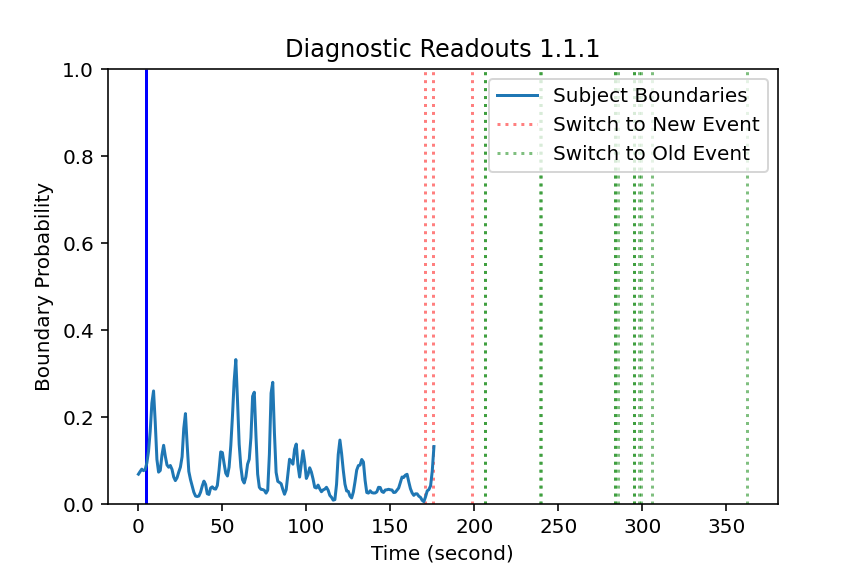
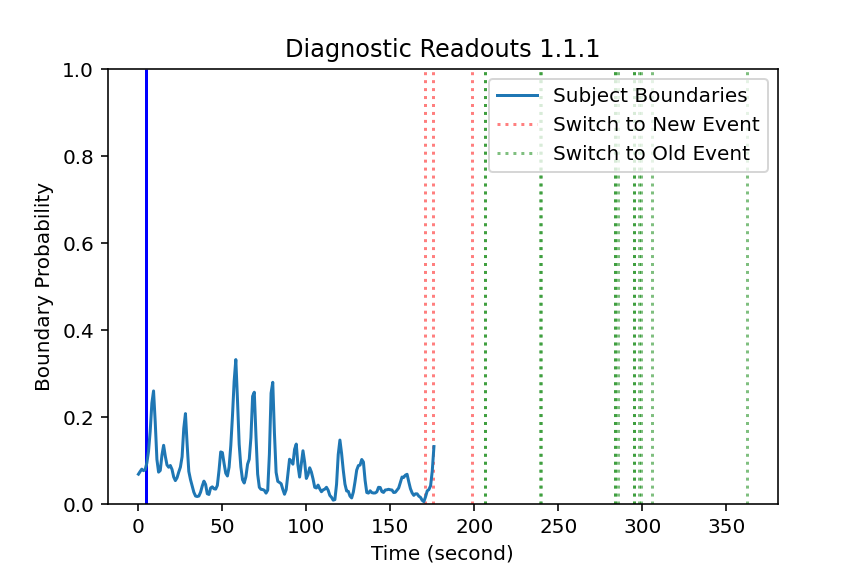
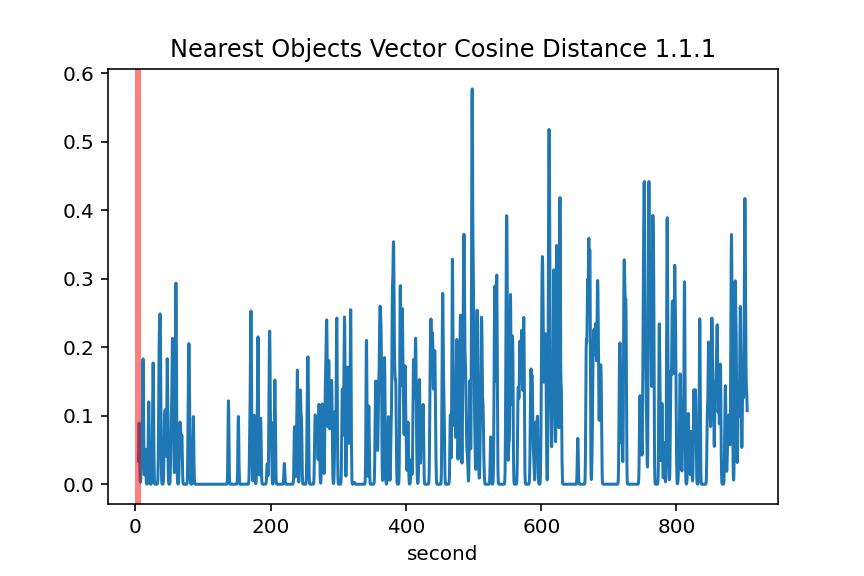
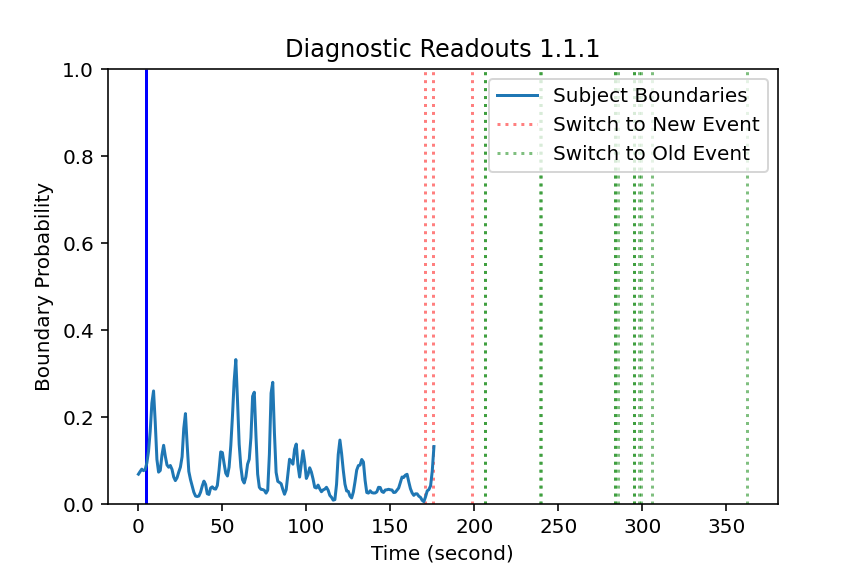
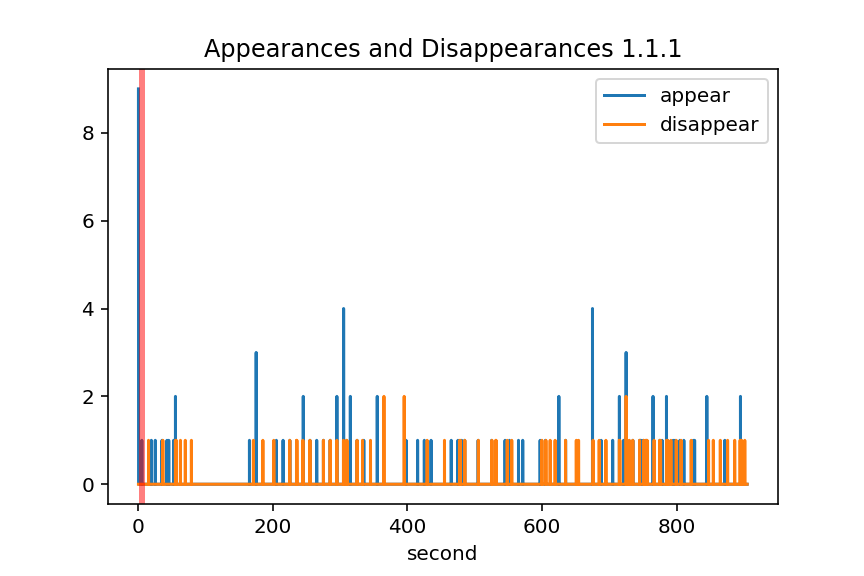
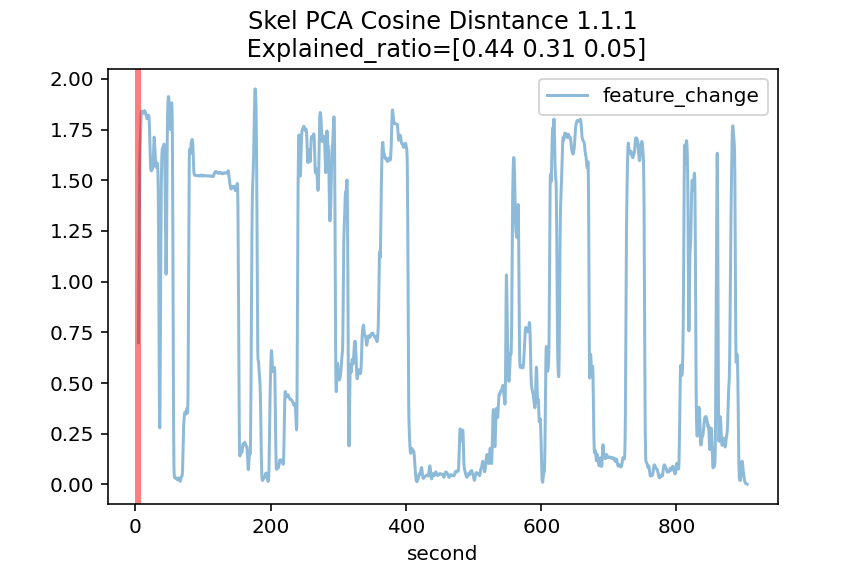
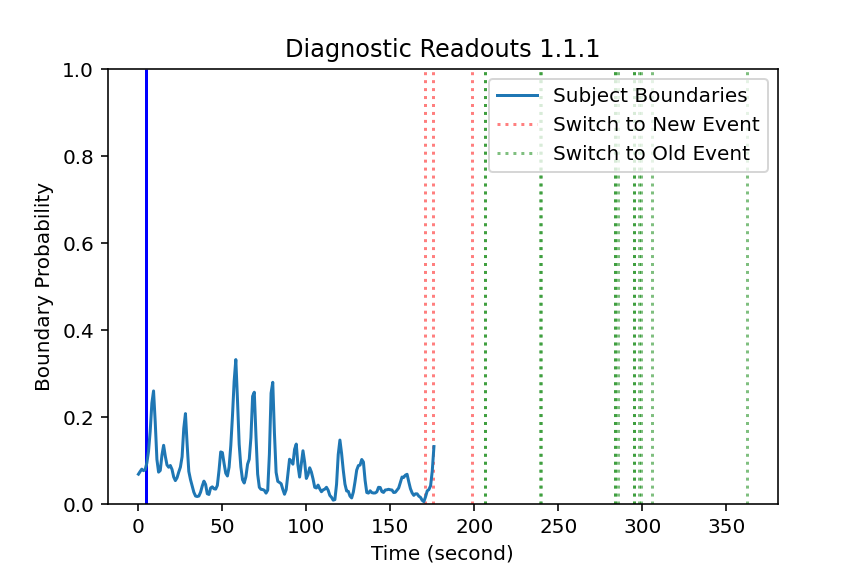

In [59]:
title = '# Visualize Input Features'

# Load sample input dfs:
runs = glob('output/skel/*_kinect_skel_features.csv')
runs = [os.path.basename(x).split('_')[0] for x in runs]
run_select = pn.widgets.Select(name='Select Run', options=runs, value=runs[0])
appeardf = pd.read_csv('output/appear/1.1.1_kinect_appear.csv')
skel_df=pd.read_csv('output/skel/1.1.1_kinect_skel_features.csv')
flowdf=pd.read_csv('output/vid/1.1.1_kinect_video_features.csv')
with open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb') as f:
    anchored_frames = pkl.load(f)
with open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb') as f:
    inputdf = pkl.load(f)
appeardf_post = inputdf[0]
skel_df_post = inputdf[2]
flowdf_post = inputdf[1]
objdf=inputdf[5]
objhanddf=inputdf[3]
i=1
dists=[0]
while i < len(objhanddf):
    dists.append(cosine(objhanddf.iloc[i],objhanddf.iloc[i-1]))
    i+=1
objhanddf['cosine']=dists
fps = 25.0 # kinect video frame rate
skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
frames=skel_df.index.tolist()
frame_slider = pn.widgets.DiscreteSlider(name='Select Frame', options=list(anchored_frames.keys()), value=list(anchored_frames.keys())[0])
features = skel_df.columns.tolist()
features = [s for s in features if s[-7:] != 'Tracked']
features = [s for s in features if s[-2:] != 'ID']
for x in ['sync_time','raw_time','frame','body']:
    features = [s for s in features if s != x]
df = skel_df.reset_index()
tc_feature_select = pn.widgets.MultiSelect(name='Select Time Course Features', value=[features[3],features[4]],
    options=features, size=8)
pair_feature_select = pn.widgets.MultiSelect(name='Select 2 or 3 Features for Comparison', value=[features[3],features[4]],
    options=features, size=8)
skel_checkbox = pn.widgets.Checkbox(name='Display Skeleton?')
obj_checkbox = pn.widgets.Checkbox(name='Display Nearest Objects?')
z_checkbox = pn.widgets.Checkbox(name='Z-score time courses?')
text_input = pn.widgets.TextInput(name='Second', placeholder='Enter timepoint (in second)')

def listen_to_text(frame_slider, text):
    frameid = int(float(text.new) * 25)
    while frameid not in anchored_frames:
        frameid += 1
    frame_slider.value = frameid
text_input.link(frame_slider, callbacks={'value': listen_to_text})

def updating_slider(target, event):
    global skel_df, appeardf, flowdf, objdf, objhanddf, anchored_frames, appeardf_post, flowdf_post, skel_df_post
    skel_df=pd.read_csv('output/skel/'+event.new+'_kinect_skel_features.csv')
    appeardf = pd.read_csv('output/appear/'+event.new+'_kinect_appear.csv')
    flowdf=pd.read_csv('output/vid/'+event.new+'_kinect_video_features.csv')
    with open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb') as f:
        anchored_frames = pkl.load(f)
    with open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb') as f:
        inputdf = pkl.load(f)
    appeardf_post = inputdf[0]
    flowdf_post = inputdf[1]
    skel_df_post = inputdf[2]
    objdf=inputdf[5]
    objhanddf=inputdf[3]
    i=1
    dists=[np.nan]
    while i < len(objhanddf):
        dists.append(cosine(objhanddf.iloc[i],objhanddf.iloc[i-1]))
        i+=1
    objhanddf['cosine']=dists
    
    framelist = list(anchored_frames.keys())
    target.options=framelist
    target.value=framelist[0]
run_select.link(frame_slider, callbacks={'value': updating_slider})


def drawskel(frame_number,frame,skel_df,color=(255,0,0),thickness=2):
    # frame_number : video frame to select skeleton joints
    # frame : image frame to draw on
    # skel_df : df of skeleton joint coordinates
    # color : RGB tuple for color
    # thinkness : thickness to draw bone lines

    # Find scale factor of video frame. Original skeleton 2D dimensions are 1080 x 1920
    s = frame.shape[0]/1080.0
    #ys = frame.shape[1]/1920.0
    #xs=1.0
    #ys=1.0
    r=skel_df[skel_df['frame'] == frame_number]
    def seg(bone,f):
        # draw segment between two joints
        ax = int(r['J'+str(bone[0])+'_2D_X'].values[0] * s)
        ay = int(r['J'+str(bone[0])+'_2D_Y'].values[0] * s)
        bx = int(r['J'+str(bone[1])+'_2D_X'].values[0] * s)
        by = int(r['J'+str(bone[1])+'_2D_Y'].values[0] * s)
        #print(ax,ay,bx,by)
        if all(x > 0 for x in (ax,ay,bx,by)):
            cv2.line(f,(ax,ay),(bx,by),color,thickness)
        return f
    for bone in [(3,2),(2,20),(20,1),(1,0),
                (21,7),(7,6),(22,6),(6,5),(5,4),(4,20),
                (20,8),(8,9),(9,10),(24,10),(10,11),(11,23),
                (0,12),(12,13),(13,14),(14,15),
                (0,16),(16,17),(17,18),(18,19)]:
        frame = seg(bone,frame)
    # Draw tracked vs inferred joints:
    for joint in range(25):
        jx = int(r['J'+str(joint)+'_2D_X'].values[0] * s)
        jy = int(r['J'+str(joint)+'_2D_Y'].values[0] * s)
        jtrack = r['J'+str(joint)+'_Tracked'].values[0]
        if (all(x > 0 for x in [jx,jy])):
            if jtrack=='Tracked':
                #draw tracked joint
                cv2.circle(frame,(jx,jy),4,(0,255,0),-1)
            elif jtrack=='Inferred':
                #draw inferred joint
                cv2.circle(frame,(jx,jy),4,(0,0,255),-1)
    return frame

def drawobj(frame_number,frame,objdf,color=(255,0,0),thickness=1):
    odf=objdf[objdf.index==frame_number]
    odf=odf[odf.columns[~odf.isna().any()].tolist()]
    instances=set([x.split('_')[0] for x in odf.columns])
    s = frame.shape[0]/540.0
    for i in instances:
        xmin=odf[i+'_x'] * s
        ymin=odf[i+'_y'] * s
        xmax=xmin+(odf[i+'_w'] * s)
        ymax=ymin+(odf[i+'_h'] * s)
        try:
            conf_score =float(odf[i+'_confidence'])
            color = tuple(map(int, np.array(color) * conf_score))
        except:
            color = (0,0,255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color, thickness=thickness)
        cv2.putText(frame, text=i,
                    org=(int(xmin), int(ymax - 5)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=color)
    return frame

#@pn.depends(frame_slider.param.value,skel_checkbox.param.value,run_select.param.value)
#def draw_frame(frame_slider,skel_checkbox,run_select):
#    vidfile='../from_chpc/small_videos/'+run_select+'_kinect_trim.mp4'
#    outframe=''
#    video_capture = cv2.VideoCapture()
#    if video_capture.open(vidfile):
#        frame_id = 0
#        total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
#        while video_capture.isOpened():
#            ret, frame = video_capture.read()
#            if not ret:
#                print('End of video stream, ret is False!')
#                break
#            if frame_id == frame_slider:
#                #outframe=Image(data=cv2.imencode('.png', frame)[1])
#                outframe=frame
#                if skel_checkbox:
#                    try:
#                        skel_df=pd.read_csv('output/skel/'+run_select+'_kinect_skel_features.csv')
#                        outframe = drawskel(frame_slider,outframe,skel_df)
#                    except:
#                        cv2.putText(outframe,'No skeleton data',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
#                    outframe=Image(data=cv2.imencode('.png', outframe)[1])
#                else:
#                    outframe=Image(data=cv2.imencode('.png', outframe)[1])
#                break
#            frame_id+=1
#        video_capture.release()
#    return outframe

# @pn.depends(frame_slider.param.value,skel_checkbox.param.value,run_select.param.value)
# def draw_frame_resampled(frame_slider, skel_checkbox, run_select):
#     # with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb') as f:
#     #     anchored_frames = pkl.load(f)
#     outframe = anchored_frames[frame_slider]
#     # draw skeleton here
#     if skel_checkbox:
#         try:
#             skel_df=pd.read_csv('output/skel/'+run_select+'_kinect_skel_features.csv')
#             outframe = drawskel(frame_slider,outframe,skel_df)
#         except:
#             cv2.putText(outframe,'No skeleton data',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
#         outframe=Image(data=cv2.imencode('.png', outframe)[1])
#     else:
#         outframe=Image(data=cv2.imencode('.png', outframe)[1])
#     return outframe

@pn.depends(frame_slider.param.value,skel_checkbox.param.value,obj_checkbox.param.value,run_select.param.value)
def draw_frame_resampled(frame_slider, skel_checkbox, obj_checkbox,run_select):
    # with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb') as f:
    #     anchored_frames = pkl.load(f)
    outframe = anchored_frames[frame_slider]
    # draw skeleton here
    if skel_checkbox:
        try:
            skel_df=pd.read_csv('output/skel/'+run_select+'_kinect_skel_features.csv')
            outframe = drawskel(frame_slider,outframe,skel_df)
        except:
            cv2.putText(outframe,'No skeleton data',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    else:
        outframe = anchored_frames[frame_slider]
    if obj_checkbox:
        outframe = drawobj(frame_slider,outframe,objdf)
    outframe=Image(data=cv2.imencode('.png', outframe)[1])
    return outframe
'''
# This function draws frames from video with already super-imposed skeleton. Can compare with live drawing method.
@pn.depends(frame_slider.param.value)
def draw_skel_frame(frame_slider):
    #vidfile='/Users/bezdek/Box/DCL_ARCHIVE/Project-SEM-Corpus/trimmed_videos/2.4.7_kinect_trim.mp4'
    #vidfile='/Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz/vid/base/2.4.7_C1_trim_tiny.mp4'
    vidfile='/Users/bezdek/Box/DCL_ARCHIVE/Project-SEM-Corpus/clean_skeleton_videos/2.4.7_kinect_skel.avi'
    video_capture = cv2.VideoCapture()
    if video_capture.open(vidfile):
        frame_id = 0
        total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
        while video_capture.isOpened():
            ret, frame = video_capture.read()
            if not ret:
                print('End of video stream, ret is False!')
                break
            if frame_id == frame_slider:
                #outframe=Image(data=cv2.imencode('.png', frame)[1])
                outframe=frame
                outframe=Image(data=cv2.imencode('.png', outframe)[1])
                break
            frame_id+=1
        video_capture.release()
    return outframe
'''
'''
@pn.depends(frame_slider.param.value)
def category(frame_slider):
    try:
        cat = catdf[catdf.index==frame_slider][[0,1,2]].values[0]
    except:
        cat = 'no categories'
    return cat
'''

#skel_df = preprocess_skel(os.path.join('output','skel','4.4.5_skel_features.csv'))
#skel_df = pd.read_csv('/Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz/skel_features_preproc/4.4.5_skel_features_preproc.csv')


#frame_slider = pn.widgets.IntSlider(name='Frame', format='0', start=int(fmin), end=int(fmax), step=1,value=int(fmin))
'''
@pn.depends(skel_checkbox.param.value,watch=True)
def _update_options(skel_checkbox):
    #video = pn.pane.Video(os.path.join('data','small_videos',vid_select), width=640, height=360, loop=False)
    allfeatures = skel_df.columns.tolist()
    feature_select.value = [allfeatures[0],allfeatures[1]]
    feature_select.options = allfeatures
'''


@pn.depends(tc_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def time_plot(tc_feature_select,frame_slider,z_checkbox,run_select): # start function
    # skel_df=pd.read_csv('output/skel/'+run_select+'_kinect_skel_features.csv')
    fps = 25.0 # kinect video frame rate
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in tc_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
            #df[feat]=df[feat].apply(zscore)
    fig1,ax1 = plt.subplots()
    df['second'] = df['frame'] / 25
    for feat in tc_feature_select:
        df.plot(kind='line', x='second', y=feat, alpha = 0.5,ax=ax1)
    ax1.axvline(frame_slider / 25,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Feature Time Course '+run_select)
    #plt.show()
    plt.close(fig1)
    return fig1

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot(frame_slider,z_checkbox,run_select): # start function
    # flowdf=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flowdf.reset_index()
    if z_checkbox:
        df['pixel_correlation'] = (df['pixel_correlation'] - df['pixel_correlation'].mean())/df['pixel_correlation'].std(ddof=0)
    fig1,ax1 = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='pixel_correlation', ax=ax1)
    ax1.axvline(frame_slider / 25,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Interframe Pixel Correlation '+run_select)
    ax1.get_legend().remove()
    #plt.show()
    plt.close(fig1)
    return fig1

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot_post(frame_slider,z_checkbox,run_select): # start function
    # flowdf=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flowdf_post.reset_index()
    if z_checkbox:
        df['optical_flow_avg'] = (df['optical_flow_avg'] - df['optical_flow_avg'].mean())/df['optical_flow_avg'].std(ddof=0)
    fig1,ax1 = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='optical_flow_avg', ax=ax1)
    ax1.axvline(frame_slider / 25,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Interframe Optical Flow Post '+run_select)
    ax1.get_legend().remove()
    #plt.show()
    plt.close(fig1)
    return fig1

@pn.depends(frame_slider.param.value,run_select.param.value)
def objhand_plot(frame_slider,run_select): # start function
    # flowdf=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    #df = objhanddf
    #i=1
    #dists=[np.nan]
    #while i < len(df):
    #    dists.append(cosine(df.iloc[i],df.iloc[i-1]))
    #    i+=1
    #df['cosine']=dists
    #df = df.reset_index()
    df = objhanddf.reset_index()
    fig1,ax1 = plt.subplots()
    df['cosine'] = gaussian_filter1d(df['cosine'], 2)
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='cosine', ax=ax1)
    ax1.axvline(frame_slider / 25,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Nearest Objects Vector Cosine Distance '+run_select)
    ax1.get_legend().remove()
    #plt.show()
    plt.close(fig1)
    return fig1

@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot(frame_slider,run_select): # start function
    # appeardf = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appeardf.reset_index()
    fig1,ax1 = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax1)
    df.plot(kind='line', x='second', y='disappear', ax=ax1)
    ax1.axvline(frame_slider / 25,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Appearances and Disappearances '+run_select)
    #ax1.get_legend().remove()
    #plt.show()
    plt.close(fig1)
    return fig1

@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot_post(frame_slider,run_select): # start function
    # appeardf = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appeardf_post.reset_index()
    fig1,ax1 = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax1)
    df.plot(kind='line', x='second', y='disappear', ax=ax1)
    ax1.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Appearances and Disappearances Post'+run_select)
    #ax1.get_legend().remove()
    #plt.show()
    plt.close(fig1)
    return fig1


@pn.depends(pair_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def pair_plot(pair_feature_select,frame_slider,z_checkbox,run_select): # start function
    # skel_df=pd.read_csv('output/skel/'+run_select+'_kinect_skel_features.csv')
    fps = 25.0 # kinect video frame rate
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in pair_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
    pdf = df[df['frame'] == frame_slider]
        
    if len(pair_feature_select) == 2:
        fig2,ax2 = plt.subplots()
        df.plot(kind='scatter', x=pair_feature_select[0], y=pair_feature_select[1],alpha=0.5,c=df['frame'],colormap='viridis',ax=ax2)
        ax2.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],marker='o',markersize=15,color='r',alpha=0.5)
    elif len(pair_feature_select) == 3:
        fig2,ax2=plt.subplots(subplot_kw=dict(projection='3d'))
        p=ax2.scatter(df[pair_feature_select[0]],df[pair_feature_select[1]],df[pair_feature_select[2]],c=df['frame'],cmap='viridis')
        ax2.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],pdf[pair_feature_select[2]],marker='o',markersize=15,color='r')
        ax2.set_xlabel(pair_feature_select[0])
        ax2.set_ylabel(pair_feature_select[1])
        ax2.set_zlabel(pair_feature_select[2])

        fig2.colorbar(p)
    else:
        fig2,ax2 = plt.subplots()
    plt.title('Compare Features '+run_select)
    plt.close(fig2)
    return fig2

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_reduced_features(frame_slider, run_select):

    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    first_frame = skel_df_post.index[0]
    offset = first_frame / 25 / second_interval
    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=2, whiten=True)
    x_train = pca.fit_transform(x_train)
    df = pd.DataFrame(x_train, index=skel_df_post.index, columns=['pc_1', 'pc_2'])
    fig2, ax2 = plt.subplots()
    df.plot(kind='scatter', x=df.columns[0], y=df.columns[1],alpha=0.5,c=df.index,colormap='viridis',ax=ax2)
    ax2.plot(df.loc[frame_slider, 'pc_1'], df.loc[frame_slider, 'pc_2'], marker='o',markersize=15,color='r',alpha=0.5)
    ax2.set_title('Principal Components for Skeletons')
    ax2.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.close()
    return fig2

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post(frame_slider, run_select):

    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    first_frame = skel_df_post.index[0]
    offset = first_frame / 25 / second_interval
    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=3, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(cosine(x_train[i], x_train[-1]))
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 2)
    fig2, ax2 = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax2)
    ax2.axvline(frame_slider / 25,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Skel PCA Cosine Disntance '+run_select+ f'\n Explained_ratio={np.round(pca.explained_variance_ratio_, 2)}')
    plt.close()
    return fig2

######## OUTPUT
outtitle = '# Visualize Output'
second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list(np.arange(600)), value=1)

# gt_freqs = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb'))
# sem_readouts = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb'))
# inputdf = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb'))

def callback(target, event):
    # global gt_freqs, sem_readouts, inputdf
    # gt_freqs = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb'))
    # sem_readouts = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb'))
    inputdf = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb'))

    appear = inputdf[0]
    framelist=list(appear.index / 25)
    target.options=framelist
    target.value=framelist[0]
    # target.object = event.new.upper() + '!!!'
run_select.link(second_slider, callbacks={'value': callback})

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_diagnostic_readouts(frame_slider, run_select, title=''):
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb') as f:
        gt_freqs = pkl.load(f)
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb') as f:
        sem_readouts = pkl.load(f)
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb') as f:
        inputdf = pkl.load(f)

    second_interval = 1
    frame_per_second = 3
    vidframe_per_second = 25
    frame_interval = frame_per_second * second_interval
    first_frame = inputdf[0].index[0]
    offset = first_frame / vidframe_per_second / second_interval

    fig, ax = plt.subplots()
    ax.plot(gaussian_filter1d(gt_freqs, 1), label='Subject Boundaries')
    ax.set_xlabel('Time (second)')
    ax.set_ylabel('Boundary Probability')
    ax.set_title('Diagnostic Readouts '+run_select)
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    sem_readouts['frame_dynamics']['old_lik'] = [[l for l in all_lik if
                                                  not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
                                                 for all_lik, new_lik, repeat_lik in
                                                 zip(sem_readouts['frame_dynamics']['old_lik'], sem_readouts['frame_dynamics']['new_lik'], sem_readouts['frame_dynamics']['repeat_lik'])]
    sem_readouts['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts['frame_dynamics']['old_lik']]
    # sem_readouts['frame_dynamics']['old_prior'] = [[p for p in all_prior if
    #                                               not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
    #                                              for all_prior, new_prior, repeat_prior in
    #                                              zip(sem_readouts['frame_dynamics']['old_prior'], sem_readouts['frame_dynamics']['new_prior'], sem_readouts['frame_dynamics']['repeat_prior'])]
    # sem_readouts['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts['frame_dynamics']['old_prior']]
    # Currently, boundaries using only likelihood
    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))
    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    df = pd.DataFrame(sem_readouts['frame_dynamics'])
    df['new_post'] = df.filter(regex='new_').sum(axis=1)
    df['old_post'] = df.filter(regex='old_').sum(axis=1)
    df['repeat_post'] = df.filter(regex='repeat_').sum(axis=1)
    df['restart_post'] = df.filter(regex='restart_').sum(axis=1)
    df['switch'] = df.filter(regex='_post').idxmax(axis=1)
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    ax.vlines([frame_slider / ( vidframe_per_second * second_interval)], ymin=0, ymax=1, alpha=1, color='blue')
    # ax.vlines(df[df['switch'] == 'repeat_post'].index, ymin=0, ymax=1, alpha=0.5, label='Repeat Event', color=colors['repeat'],
    #            linestyles='dotted')
    # ax.vlines(df[df['switch'] == 'restart_post'].index, ymin=0, ymax=1, alpha=0.5, label='Restart Event', color=colors['restart'],
    #            linestyles='dotted')
    ax.legend()
    ax.set_ylim([0, 1.0])
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_likelihood(frame_slider, run_select):
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb') as f:
        sem_readouts = pkl.load(f)
    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))
    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    vidframe_per_second = 25
    fig, ax = plt.subplots()
    ax.plot(sem_readouts['frame_dynamics']['new_lik'], alpha=0.4, label='new_lik')
    tmp = []
    for repeat, restart in zip(sem_readouts['frame_dynamics']['repeat_lik'], sem_readouts['frame_dynamics']['restart_lik']):
        tmp.append(np.log(np.exp(repeat) - np.exp(restart)))
    ax.plot(tmp, alpha=0.4, label='repeat_lik')
    ax.plot(sem_readouts['frame_dynamics']['restart_lik'], alpha=0.4, label='restart_lik')
    ax.plot(sem_readouts['frame_dynamics']['old_lik'], alpha=0.4, label='old_lik')
    ax.vlines([frame_slider * (second_interval/vidframe_per_second)], ymin=-5, ymax=5, alpha=1, color='blue')
    ax.set_ylim([-5 * 1, 5 * 1])
    ax.legend()
    ax.set_title('Likelihood '+run_select)
    ax.set_ylabel('Log-likelihood')
    ax.set_xlabel('Time-step (3steps=1second)')
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_prior(frame_slider, run_select):
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb') as f:
        sem_readouts = pkl.load(f)
    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    vidframe_per_second = 25
    fig, ax = plt.subplots()
    ax.plot(sem_readouts['frame_dynamics']['new_prior'], alpha=0.4, label='new_prior')
    ax.plot(sem_readouts['frame_dynamics']['repeat_prior'], alpha=0.4, label='current_repeat_prior')
    ax.plot(sem_readouts['frame_dynamics']['restart_prior'], alpha=0.4, label='current_restart_prior')
    # ax.plot(sem_readouts['frame_dynamics']['old_prior'], alpha=0.4, label='old_prior')
    ax.vlines([frame_slider * (second_interval/vidframe_per_second)], ymin=-5, ymax=5, alpha=1, color='blue')
    ax.set_ylim([-1 * 1, 1 * 1])
    ax.legend()
    ax.set_title('Prior '+run_select)
    plt.close()
    return fig


#########

# Arrange dashboard elements
# dashboard = pn.Column(
#     pn.Row(title),
#     pn.Row(run_select),
#     pn.Row(frame_slider,text_input, skel_checkbox,obj_checkbox,z_checkbox),
#     pn.Row(tc_feature_select,time_plot,flow_plot),
#     pn.Row(pair_feature_select,pair_plot,appear_plot, appear_plot_post),
#     pn.Row(draw_frame_resampled,objhand_plot,plot_reduced_features),
#     pn.Row(outtitle),
#     pn.Row(plot_likelihood, plot_prior, plot_diagnostic_readouts))

dashboard = pn.Column(
    pn.Row(title),
    pn.Row(run_select),
    pn.Row(frame_slider,text_input, skel_checkbox,obj_checkbox,z_checkbox),
    pn.Row(pn.Column(flow_plot_post, plot_diagnostic_readouts), pn.Column(appear_plot, plot_diagnostic_readouts), 
           pn.Column(objhand_plot, plot_diagnostic_readouts), pn.Column(skel_plot_post, plot_diagnostic_readouts)),
    pn.Row(draw_frame_resampled),
)

# Launch the dashboard
dashboard.servable()

In [57]:
    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    first_frame = skel_df_post.index[0]
    offset = first_frame / 25 / second_interval
    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=3, whiten=True)
    x_train = pca.fit_transform(x_train)
    np.round(pca.explained_variance_ratio_, 2)

array([0.44, 0.31, 0.05])

In [23]:
'''
# %%
from scipy.ndimage import gaussian_filter1d

title = '# Visualize Output Features'
runs = glob('output/skel/*_kinect_skel_features.csv')
runs = [os.path.basename(x).split('_')[0] for x in runs]
run_select = pn.widgets.Select(name='Select Run', options=runs, value=runs[0])
second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list(np.arange(600)), value=1)

# gt_freqs = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb'))
# sem_readouts = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb'))
# inputdf = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb'))

def callback(target, event):
    # global gt_freqs, sem_readouts, inputdf
    # gt_freqs = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb'))
    # sem_readouts = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb'))
    inputdf = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb'))

    appear = inputdf[0]
    framelist=list(appear.index / 25)
    target.options=framelist
    target.value=framelist[0]
    # target.object = event.new.upper() + '!!!'
run_select.link(second_slider, callbacks={'value': callback})

@pn.depends(second_slider.param.value, run_select.param.value)
def plot_diagnostic_readouts(second_slider, run_select, title=''):
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb') as f:
        gt_freqs = pkl.load(f)
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb') as f:
        sem_readouts = pkl.load(f)
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb') as f:
        inputdf = pkl.load(f)

    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    first_frame = inputdf[0].index[0]
    offset = first_frame / 25 / second_interval

    fig, ax = plt.subplots()
    ax.plot(gaussian_filter1d(gt_freqs, 1), label='Subject Boundaries')
    ax.set_xlabel('Time (3seconds)')
    ax.set_ylabel('Boundary Probability')
    ax.set_title('Diagnostic Readouts')
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    sem_readouts['frame_dynamics']['old_lik'] = [[l for l in all_lik if
                                                  not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
                                                 for all_lik, new_lik, repeat_lik in
                                                 zip(sem_readouts['frame_dynamics']['old_lik'], sem_readouts['frame_dynamics']['new_lik'], sem_readouts['frame_dynamics']['repeat_lik'])]
    sem_readouts['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts['frame_dynamics']['old_lik']]
    # sem_readouts['frame_dynamics']['old_prior'] = [[p for p in all_prior if
    #                                               not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
    #                                              for all_prior, new_prior, repeat_prior in
    #                                              zip(sem_readouts['frame_dynamics']['old_prior'], sem_readouts['frame_dynamics']['new_prior'], sem_readouts['frame_dynamics']['repeat_prior'])]
    # sem_readouts['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts['frame_dynamics']['old_prior']]
    # Currently, boundaries using only likelihood
    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))
    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    df = pd.DataFrame(sem_readouts['frame_dynamics'])
    df['new_post'] = df.filter(regex='new_').sum(axis=1)
    df['old_post'] = df.filter(regex='old_').sum(axis=1)
    df['repeat_post'] = df.filter(regex='repeat_').sum(axis=1)
    df['restart_post'] = df.filter(regex='restart_').sum(axis=1)
    df['switch'] = df.filter(regex='_post').idxmax(axis=1)
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    ax.vlines([second_slider // second_interval], ymin=0, ymax=1, alpha=1, color='blue')
    # ax.vlines(df[df['switch'] == 'repeat_post'].index, ymin=0, ymax=1, alpha=0.5, label='Repeat Event', color=colors['repeat'],
    #            linestyles='dotted')
    # ax.vlines(df[df['switch'] == 'restart_post'].index, ymin=0, ymax=1, alpha=0.5, label='Restart Event', color=colors['restart'],
    #            linestyles='dotted')
    ax.legend()
    ax.set_ylim([0, 1.0])
    plt.close()
    return fig


@pn.depends(second_slider.param.value, run_select.param.value)
def plot_likelihood(second_slider, run_select):
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb') as f:
        sem_readouts = pkl.load(f)
    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))
    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    fig, ax = plt.subplots()
    ax.plot(sem_readouts['frame_dynamics']['new_lik'], alpha=0.4, label='new_lik')
    tmp = []
    for repeat, restart in zip(sem_readouts['frame_dynamics']['repeat_lik'], sem_readouts['frame_dynamics']['restart_lik']):
        tmp.append(np.log(np.exp(repeat) - np.exp(restart)))
    ax.plot(tmp, alpha=0.4, label='repeat_lik')
    ax.plot(sem_readouts['frame_dynamics']['restart_lik'], alpha=0.4, label='restart_lik')
    ax.plot(sem_readouts['frame_dynamics']['old_lik'], alpha=0.4, label='old_lik')
    ax.vlines([second_slider * frame_per_second], ymin=-5, ymax=5, alpha=1, color='blue')
    ax.set_ylim([-5 * 1, 5 * 1])
    ax.legend()
    ax.set_title('Likelihood')
    ax.set_xlabel('Log-likelihood')
    ax.set_ylabel('Time-step (3steps=1second)')
    plt.close()
    return fig


@pn.depends(second_slider.param.value, run_select.param.value)
def plot_prior(second_slider, run_select):
    with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb') as f:
        sem_readouts = pkl.load(f)
    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    second_interval = 1
    frame_per_second = 3
    frame_interval = frame_per_second * second_interval
    fig, ax = plt.subplots()
    ax.plot(sem_readouts['frame_dynamics']['new_prior'], alpha=0.4, label='new_prior')
    ax.plot(sem_readouts['frame_dynamics']['repeat_prior'], alpha=0.4, label='current_repeat_prior')
    ax.plot(sem_readouts['frame_dynamics']['restart_prior'], alpha=0.4, label='current_restart_prior')
    # ax.plot(sem_readouts['frame_dynamics']['old_prior'], alpha=0.4, label='old_prior')
    ax.vlines([second_slider * frame_per_second], ymin=-5, ymax=5, alpha=1, color='blue')
    ax.set_ylim([-1 * 1, 1 * 1])
    ax.legend()
    ax.set_title('Prior')
    plt.close()
    return fig

# Arrange dashboard elements
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(run_select, second_slider),
    pn.Row(plot_likelihood, plot_prior, plot_diagnostic_readouts)
)

# Launch the dashboard
dashboard.servable()

'''

"\n# %%\nfrom scipy.ndimage import gaussian_filter1d\n\ntitle = '# Visualize Output Features'\nruns = glob('output/skel/*_kinect_skel_features.csv')\nruns = [os.path.basename(x).split('_')[0] for x in runs]\nrun_select = pn.widgets.Select(name='Select Run', options=runs, value=runs[0])\nsecond_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list(np.arange(600)), value=1)\n\n# gt_freqs = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb'))\n# sem_readouts = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_diagnostic.pkl', 'rb'))\n# inputdf = pkl.load(open(f'output/run_sem/1.1.1_kinect_trimjan_09_333_less_boundaries_inputdf.pkl', 'rb'))\n\ndef callback(target, event):\n    # global gt_freqs, sem_readouts, inputdf\n    # gt_freqs = pkl.load(open(f'output/run_sem/{event.new}_kinect_trimjan_09_333_less_boundaries_gtfreqs.pkl', 'rb'))\n    # sem_readouts = pkl.load(open(f'output/run_sem/{event.new}_kinect_t